<a href="https://colab.research.google.com/github/christvalt/MorphedImageAttactCNN/blob/main/Artificial_Vision_Project_Morphing_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline



Modello realizzato da zero e Finetuning 
=============================




Inizializzazione librerie

In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102


# Caricamento dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Inputs
------

In questa parte inizializiamo i parametri che veranno utilizzati per tutte le nostre reti.
 Il
``model_name`` input è il nome del model che scegliam di utilizzare
::

   [alexnet, vgg]

 ``num_classes`` rappresenta il numero di classe del dataset , ``batch_size`` rapresenta il  batch size utilizzato per il training , ``num_epochs`` numero di epoche per il training  che vogliamo utulizzare,
 ``feature_extract``  è un boleano che rapresenta si si vuole fare il fine tuning opure la feature extration . se ``feature_extract = False``,il modello è finetune quindi tutti i parametri del modello  sarano aggiornati. Se
``feature_extract = True``,  solo gli ultimi parametri del layer vengono aggiornati, gli altri rimangono fissi.




In [4]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "/content/gdrive/MyDrive/DataSet"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"
#model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Inizializzazione librerie per la face detection 

In [ ]:
#@title 
!pip install -q face_recognition
!pip install -q fer

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
%matplotlib inline
import face_recognition
import numpy as np
from PIL import ImageDraw
from PIL import Image
import PIL.Image
from io import BytesIO
from fer import FER
import cv2
import operator
import time
from google.colab import files
from google.colab.patches import cv2_imshow
detector = FER()
import os       ## For Reading the file name
from PIL import Image
import numpy as np
from array import array
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


# Face detection

In [ ]:
db_path = '/content/morph'

def read_img(path):
   img = cv2.imread(path) ## reading image
   (h,w) = img.shape[:2]  ## fetching height and width
   width = 500            ## hard coding width
   ratio = width / float(w) ## preparing a ration for height
   height = int(h * ratio)  ## generating new height
   return cv2.resize(img,(width,height)) ##return the reshaped image


known_encodings = [] 
known_names = []
directory = '/content/londondb_morph_combined_alpha0.5_passport-scale_15kb'
trainM='/content/gdrive/MyDrive/DataSet/train/MorphedT'
trainB='/content/gdrive/MyDrive/DataSet/train/bona_fedeT'
testM='/content/gdrive/MyDrive/DataSet/val/MorphedV'
testB='/content/gdrive/MyDrive/DataSet/val/bona_fedeV'
prova='/content/gdrive/MyDrive/DataSet/trainMorphed'
import skimage.io as io

for file in os.listdir(trainM):
  img = read_img(os.path.join(trainM, file))
  face_locations = face_recognition.face_locations(img)
  known_names.append(file.split('.')[0])
  known_encodings.append(face_locations)
  
  for (top, right, bottom, left) in face_locations:
        top, right, bottom, left = face_recognition.face_locations(img)[0]
        cv2.rectangle(img, (right, bottom),(left, top), (0, 0, 255), 2)
        
        #Crop selected roi from raw image
        #pil=Image.fromarray(images[0])
        #y en haut=top,bottom ,left,x large a gauche=right
        #cropped_image = img[170:439, 82:350]
        cropped_image = img[top:bottom, left:right]
        gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        #cv2.imwrite(file, cropped_image)
        cv2.imwrite(os.path.join(prova,file),cropped_image)
        cv2.waitKey(0)
       # risized=cv2.resize(gray, (227, 227), interpolation=cv2.INTER_LINEAR)
        #cv2_imshow(risized)
        #cv2_imshow(gray)
        #cv2_imshow(img)



metodo training e validation 
----------------

Prima di scrivere il codice per la regolazione dei due modelli, definiamone alcuni funzioni di supporto.

Codice di training e validation  del modello


In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
#
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Set Model Parameters’ .requires_grad attribute



In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Inizializzione e rimodellamento delle reti
-----------------------------------
Qui è dove gestiamo il rimodellamento di ciascuna rete. noi cambiamo il livello fully connected che initialmente essendo preadestrato su imagenet era a 1000 classi di output in due classi per la classifiazine del nostro modello.Quando si estraggono le feature, vogliamo solo aggiornare i parametri dell'ultimo layer, o in altre parole, vogliamo solo aggiornare i parametri per i layer che stiamo rimodellando. Pertanto, non abbiamo bisogno di calcolare i gradienti dei parametri che non stiamo modificando, quindi per l'efficienza impostiamo l'attributo .requires_grad su False

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement
    model_ft = None
    input_size = 0
    if model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 227
        layer = model_ft._modules.get('avgpool')
    elif model_name == "vgg":
        """ VGG19_bn
        """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Pre-prosessing e data aumentation
---------
in questa fase,vengono effetuati trasformazioni dei dati, i set di dati delle immagini e i dataloader. Notare che i modelli sono stati preaddestrati con alcuni valori di normalizzazione che abbiamo resprttato .




In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
if model_name == "alexnet":
    #test
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        #Resize the image to 256×256 pixels.
        transforms.Resize(256),
        # Crop the image to 224×224 pixels about the center.
        transforms.CenterCrop(227),
        # Convert the image to PyTorch Tensor data type.
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomAffine(degrees =0, translate = (0, +1)),
        #Normalize the image by setting its mean and standard deviation to the specified values.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
elif model_name == "vgg":
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        #Resize the image to 256×256 pixels.
        transforms.Resize(256),
        # Crop the image to 224×224 pixels about the center.
        transforms.CenterCrop(224),
        # Convert the image to PyTorch Tensor data type.
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        #Normalize the image by setting its mean and standard deviation to the specified values.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creazione dell'Optimizer
--------------------
Ora che la struttura del modello è corretta, il passaggio finale per la messa a punto
per l'estrazione delle funzionalità consiste nel creare un ottimizzatore che aggiorni solo il parametri desiderati.Quindi tutti i parametri che hanno .requeres_grad=True dovrebbe essere ottimizzato .Poi facciamo un elenco di tali parametri e gli inseriamo nel costruttore dell'algoritmo SGD




In [9]:
# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:
	 classifier.6.weight
	 classifier.6.bias


Running del modello di Training e Validation
--------------------------------

Infine, l'ultimo passaggio consiste nell'impostare la loss  per il modello,Poi eseguire il training e il validation  per il numero di epoche impostato.




In [10]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.2640 Acc: 0.9478
val Loss: 0.1840 Acc: 0.9516

Epoch 1/4
----------
train Loss: 0.2213 Acc: 0.9501
val Loss: 0.2106 Acc: 0.9537

Epoch 2/4
----------
train Loss: 0.2163 Acc: 0.9495
val Loss: 2.3394 Acc: 0.1095

Epoch 3/4
----------
train Loss: 0.2259 Acc: 0.9456
val Loss: 0.2415 Acc: 0.9158

Epoch 4/4
----------
train Loss: 0.2376 Acc: 0.9473
val Loss: 0.9561 Acc: 0.5221

Training complete in 7m 33s
Best val Acc: 0.953684


In [ ]:
model_path ="./content"
torch.save(model_ft.state_dict(), "alexnetModel.pth")

Confronto con il modello addestrato da zero
------------------------------------------

Solo per motivo di test , proviamo a addestrare i modeli da zero e vediamo come avvengono i risultati.




Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2839 Acc: 0.9562
val Loss: 0.1957 Acc: 0.9516

Epoch 1/4
----------
train Loss: 0.1878 Acc: 0.9562
val Loss: 0.2044 Acc: 0.9516

Epoch 2/4
----------
train Loss: 0.1878 Acc: 0.9562
val Loss: 0.1991 Acc: 0.9516

Epoch 3/4
----------
train Loss: 0.1903 Acc: 0.9562
val Loss: 0.2228 Acc: 0.9516

Epoch 4/4
----------
train Loss: 0.1876 Acc: 0.9562
val Loss: 0.1971 Acc: 0.9516

Training complete in 21m 42s
Best val Acc: 0.951579


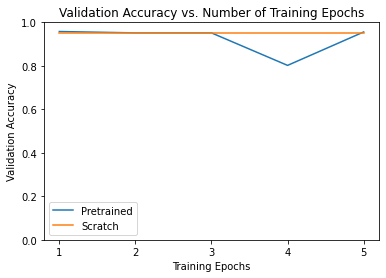

In [21]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [22]:
torch.save(scratch_model.state_dict(), "alexnetModelScratch.pth")

# Matrice di confusione

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs,labels in dataloaders_dict['val']:
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('bona_fede','Morphed')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')